In [14]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
import time

In [3]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
    
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.plot_flag:
            self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        if self.plot_flag:
            self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
            self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        return l

0.8127999901771545


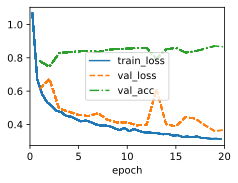

In [8]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

1. Change the number of hidden units num_hiddens and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?

As the number of hidden units grows, accuracy of the model increases first and then goes down.

In [ ]:
num_list = d2l.gen_logrithm_nums(initial_value = 64, growth_factor = 2, num_elements = 10)
data = d2l.FashionMNIST(batch_size=256)
acc_list = []

for num in num_list:
    model = MLP(num_outputs=10, num_hiddens=num, lr=0.1, plot_flag=False)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    acc = model.accuracy(y_hat,data.val.targets).item()
    acc_list.append(acc)

plt.plot(num_list, acc_list)
plt.show()

2. Try adding a hidden layer to see how it affects the results.

The accuracy increased a little.  

acc: 0.82


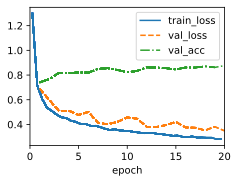

In [9]:
class MLP2(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

model = MLP2(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32)) 
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')

3. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?

A single neuron in a hidden layer loses a lot of information in the high-dimensional input. It limits the expressive power of the network. A single neuron can easily become biased towards capturing a specific pattern or representation, leading to poor generalization to new data.

4. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?

(1) change learning rate: the accuracy first increases then decreases. $lr=0.1$ gives the best result.

In [ ]:
lrs = [0.001, 0.01, 0.1, 0.3, 0.7]
data = d2l.FashionMNIST(batch_size=256)
acc_list = []

for lr in lrs:
    model = MLP(num_outputs=10, num_hiddens=num, lr=lr, plot_flag=False)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    acc = model.accuracy(y_hat,data.val.targets).item()
    acc_list.append(acc)

plt.plot(lrs, acc_list)
plt.show()

(2) change the number of epochs: As the number of epochs increases, train accuracy goes up, while test accuracy improves first and decrease latter.

5. Let’s optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
   1. What is the best result you can get by optimizing over all of them?
   2. Why it is much more challenging to deal with multiple hyperparameters?
   3. Describe an efficient strategy for optimizing over multiple parameters jointly.

(1) The best result I can get:

In [ ]:
class MLP2(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

model = MLP2(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32)) 
print(f'acc: {model.accuracy(y_hat,data.val.targets).item():.2f}')

(2) These hyperparameters need to set before learning. So I can only optimize it by training multiple times. Because these parameters affect each other, we have a large number of combinations to test. It is very time consuming.

(3) One commonly used strategy is Bayesian Optimization, which combines probability models and an acquisition function to guide the search towards promising regions of the hyperparameter space. 

https://pandalab.me/archives/implementation_of_multilayer_perceptrons

6. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?

In [16]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

class MulMLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        bef = num_inputs
        self.W = []
        self.b = []
        for num_hidden in num_hiddens:
            self.W.append(nn.Parameter(torch.randn(bef, num_hidden)*sigma))
            self.b.append(nn.Parameter(torch.zeros(num_hidden)))
            bef = num_hidden
        self.W.append(nn.Parameter(torch.randn(bef, num_outputs)*sigma))
        self.b.append(nn.Parameter(torch.zeros(num_outputs)))
        
        
    def forward(self, X):
        H = X.reshape(-1, self.num_inputs)
        for i in range(len(self.W)-1):
            H = relu(torch.matmul(H, self.W[i]) + self.b[i])
        return torch.matmul(H, self.W[-1]) + self.b[-1]
    
    def configure_optimizers(self):
        return d2l.SGD([*self.W, *self.b], self.lr)

class MulMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for num in num_hiddens:
            layers.append(nn.LazyLinear(num))
            layers.append(nn.ReLU())
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)

def stat_time(model, data):
    t0 = time.time()
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    return time.time() - t0

In [ ]:
num_hiddens=[256,128,64,32,16]
ts = []
ts_strach = []
for i in range(1,len(num_hiddens)+1):
    model = MulMLP(num_outputs=10, num_hiddens=num_hiddens[:i], lr=0.1)
    model_scratch = MulMLPScratch(num_inputs=784, num_outputs=10, num_hiddens=num_hiddens[:i], lr=0.1)
    ts_strach.append(stat_time(model_scratch, data))
    ts.append(stat_time(model, data))

In [ ]:
plt.plot(list(range(1,len(num_hiddens)+1)), ts, label="concise")
plt.plot(list(range(1,len(num_hiddens)+1)), ts_strach, label="strach")
plt.legend()
plt.show()

7. Measure the speed of tensor–matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
   1. How does this change between GPUs and CPUs?
   2. Determine the memory bus width of your CPU and GPU.

In [18]:
import torch
import time

# List of matrix dimensions to test
matrix_dimensions = [1024, 1025, 1026, 1028, 1032]

# Perform tensor-matrix multiplication and measure execution time
def measure_multiplication_speed(matrix_dim, device):
    torch.manual_seed(42)  # Set seed for reproducibility
    matrix = torch.randn(matrix_dim, matrix_dim).to(device)
    vector = torch.randn(matrix_dim, 1).to(device)
    
    start_time = time.time()
    result = torch.matmul(matrix, vector)
    end_time = time.time()
    
    execution_time = end_time - start_time
    return execution_time

# Test on CPU
print("CPU:")
for dim in matrix_dimensions:
    cpu_time = measure_multiplication_speed(dim, 'cpu')
    print(f"Matrix Dimension: {dim}, CPU Execution Time: {cpu_time:.6f} seconds")

# Test on GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("\nGPU:")
    for dim in matrix_dimensions:
        gpu_time = measure_multiplication_speed(dim, device)
        print(f"Matrix Dimension: {dim}, GPU Execution Time: {gpu_time:.6f} seconds")
else:
    print("\nGPU not available.")

# Determine memory bus width (for example, on NVIDIA GPUs)
if torch.cuda.is_available():
    gpu = torch.device("cuda")
    print("\nGPU Memory Bus Width:")
    print(torch.cuda.get_device_properties(gpu).pci_bus_id)
else:
    print("\nGPU not available.")

CPU:
Matrix Dimension: 1024, CPU Execution Time: 0.000000 seconds
Matrix Dimension: 1025, CPU Execution Time: 0.000000 seconds
Matrix Dimension: 1026, CPU Execution Time: 0.000000 seconds
Matrix Dimension: 1028, CPU Execution Time: 0.000000 seconds
Matrix Dimension: 1032, CPU Execution Time: 0.000997 seconds

GPU not available.

GPU not available.


CPU memory bus width?

The addressable memory size is 16GB(RAM size), which is equivalent to 2^24 Bytes.

The Address Bus Width = log2(2^24) = 24

8. Try out different activation functions. Which one works best?

In [19]:
class ActMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, act, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 act, nn.LazyLinear(num_outputs))
    
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.plot_flag:
            self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        if self.plot_flag:
            self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
            self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        return l
        
def stat_act(act, data):
    model = ActMLP(num_outputs=10, num_hiddens=256, lr=0.1, act=act, plot_flag=False)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)
    y_hat = model(data.val.data.type(torch.float32))
    return model.accuracy(y_hat,data.val.targets).item()

acts = [nn.ReLU(),nn.Sigmoid(), nn.Tanh(),nn.LeakyReLU(negative_slope=0.01),nn.PReLU(num_parameters=1)]
accs = []
for act in acts:
    accs.append(stat_act(act, data))

c:\Users\zjp20\miniconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


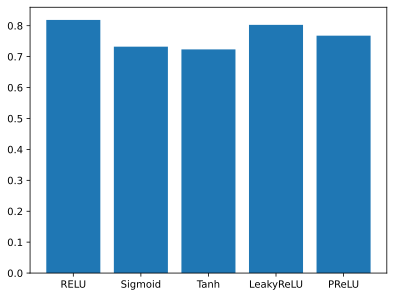

In [20]:
x = ['RELU','Sigmoid','Tanh','LeakyReLU','PReLU']
plt.bar(x, accs)
plt.show()

9. Is there a difference between weight initializations of the network? Does it matter?

Weight initialization plays a crucial role in the convergence speed and stability of training, as well as the overall performance of a neural network.

Poor weight initialization can lead to vanishing or exploding gradients, where the gradients become very small or very large as they are backpropagated through the network during training. This can slow down or hinder the convergence of the optimization process.

Common weight initialization methods include Xavier/Glorot initialization, He initialization, uniform initialization, and normal initialization. The specific choice of initialization method depends on the network architecture, the activation functions used, and the problem domain.